In [32]:
import os
import sys

import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import norm
from scipy.special import erf
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

from astropy import units as u
from astropy.coordinates import SkyCoord

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from main_code.utils.constants import *
from main_code.utils.functions import *
from main_code.utils.CosmoFunc import *

from scipy.stats import norm

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [-3.0, 0.0, 3.0]
        return np.ma.masked_array(np.interp(value, x, y))

# Sky coverage vs PV

Min PV: 3007.736870494532 | Max PV: 16118.946112772173
Min PV: 3012.9142029 | Max PV: 16119.840466659998
Min PV: 3016.0798495446206 | Max PV: 16118.141246446074


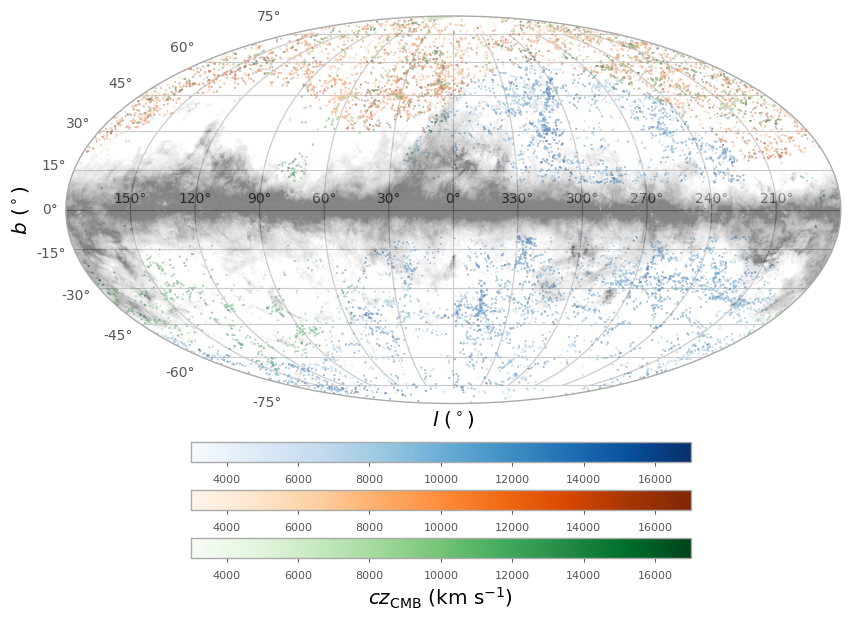

In [ ]:
# Plot Mollweide projections
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='mollweide')

cmaps = ['Blues', 'Oranges', 'Greens']
scatters = []
cbar_coords = [
    [0.25, 0.18, 0.5, 0.025],
    [0.25, 0.12, 0.5, 0.025],
    [0.25, 0.06, 0.5, 0.025]
]

for i, survey in enumerate(SURVEY_LIST): 
    df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")[['tmass', 'ra', 'dec', 'z_dist_est', 'logdist_common_abc', 'logdist_err_common_abc']]

    # Calculate peculiar velocities from logdists
    df['cz'] = LIGHTSPEED * df['z_dist_est']
    print(f"Min cz: {df['cz'].min()} | Max PV: {df['cz'].max()}")

    ra = df['ra'].to_numpy()
    dec = df['dec'].to_numpy()
    c_icrs = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')

    # Get Galactic coordinates
    gal_lon = - c_icrs.galactic.l.wrap_at(180 * u.degree).radian
    gal_lat = c_icrs.galactic.b.radian

    # Plot galaxy distribution, color-coded by redshift
    sc = ax.scatter(gal_lon, gal_lat, s=0.1, c=df['cz'], cmap=cmaps[i], vmin=3000, vmax=17000)
    scatters.append(sc)

    # cbars.append(plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05, shrink=0.7, aspect=30))
    cbar_ax = fig.add_axes(cbar_coords[i])
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', pad=0.05, shrink=0.7, aspect=30)

    # cbar_ax.set_xticklabels([label_list], fontsize=10)
    cbar_ax.set_xticks([num * 1000 for num in list(range(4, 17, 2))])
    cbar_ax.tick_params(axis='x', labelsize=8, direction="out")
    cbar_ax.tick_params(axis='both', which='major', length=3)

cbar_ax.set_xlabel(r'$cz_\mathrm{CMB}$ (km s$^{-1}$)')

# Plot dust data
dust_data = pd.read_csv("../data/external/mw_dust/dust_data.csv")
norm = MidpointNormalize(midpoint=-1.0)
ra_dust = dust_data['ra_dust'].to_numpy()
dec_dust = dust_data['dec_dust'].to_numpy()
dust_coords = SkyCoord(ra=ra_dust * u.radian, dec=dec_dust * u.radian, frame='icrs')
dust_gal_l = - dust_coords.galactic.l.wrap_at(180 * u.degree).radian
dust_gal_b = dust_coords.galactic.b.radian
ax.scatter(dust_gal_l, dust_gal_b, s=0.1, c=dust_data['ebv_dust'], 
           edgecolors='none', cmap='Greys', norm=norm, alpha=0.3, rasterized=True)

# Custom x-tick positions and labels (centered at 0°)
label_map = {
    -150: '150°',
    -120: '120°',
    -90: '90°',
    -60: '60°',
    -30: '30°',
    0: '0°',
    30: '330°',
    60: '300°',
    90: '270°',
    120: '240°',
    150: '210°'
}
label_list = [label_map[key] for key in label_map]
ax.set_xticklabels(label_list, fontsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.set_ylabel(r'$b$ ($^\circ$)')
ax.set_xlabel(r'$l$ ($^\circ$)')

fig.savefig('../img/final_plot/sky_distributions.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Distribution of peculiar velocities

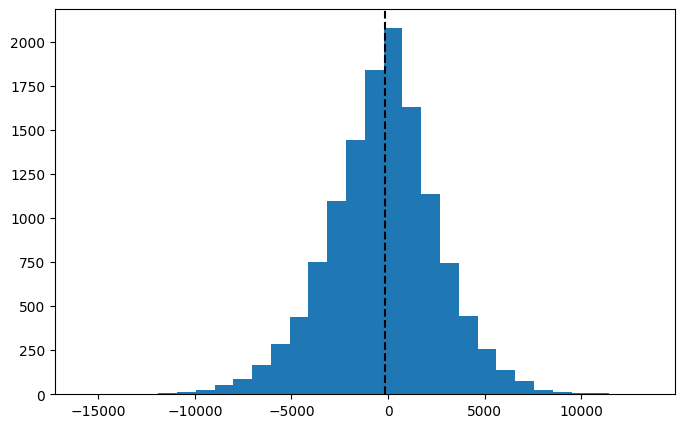

In [171]:
mpl.style.use('default')

# Load full data
df = pd.DataFrame()
for i, survey in enumerate(SURVEY_LIST):
    df_temp = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")

    df = pd.concat([df, df_temp])

# Calculate peculiar velocity
df['pv'] = LIGHTSPEED * df['z_dist_est'] * df['logdist_common_abc'] * np.log(10) / (1 + 0.75 * df['z_dist_est'])

# Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))

x = df['pv'].to_numpy()
x_mean = np.mean(x)
x_median = np.median(x)

ax.hist(x, bins=30)
ax.axvline(x=x_median, c='k', ls='--')

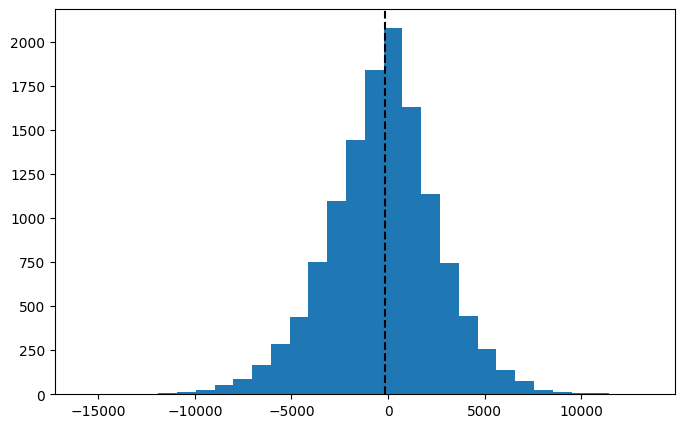

In [172]:
mpl.style.use('default')

# Load full data
df = pd.DataFrame()
for i, survey in enumerate(SURVEY_LIST):
    df_temp = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")

    df = pd.concat([df, df_temp])

# Calculate peculiar velocity
df['pv'] = LIGHTSPEED * df['z_dist_est'] * df['logdist_common_abc'] * np.log(10) / (1 + 0.75 * df['z_dist_est'])

# Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))

x = df['pv'].to_numpy()
x_mean = np.mean(x)
x_median = np.median(x)

ax.hist(x, bins=30)
ax.axvline(x=x_median, c='k', ls='--')